In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pymc3 as pm
from sklearn.preprocessing import LabelEncoder

In [3]:
import seaborn as sns

### Loading  & cleaning results data

Flores dataset results

In [4]:
flores_full = pd.read_csv('./evaluate/all_results_112420.csv')
flores_full.method = flores_full.method.str.replace('baseline-fp16', 'sentencepiece')

WMT19 results before additional data, i.e. KK 120k

In [5]:
wmt19_results_old = pd.read_csv('evaluate/all_wmt19_results_112420.csv')
wmt19_results_old.method = wmt19_results_old.method.replace('baseline', 'sentencepiece')

WMT19 results with additional data, i.e. KK 220K

In [6]:
wmt19_results_220k_old = pd.read_csv('./evaluate/all_wmt19_results_additional_112420.csv')
wmt19_results_220k_old.method = wmt19_results_220k_old.method.str.replace('baseline', 'sentencepiece')

In [172]:
wmt19_results_220k_old[wmt19_results_220k_old.pair == 'kk-en'].shape

(20, 5)

In [173]:
wmt19_results_220k_old[wmt19_results_220k_old.pair == 'en-kk'].shape

(20, 5)

WMT19 KK 220k re-run for MORSEL and LMVR

In [179]:
wmt19_results_220k_rerun = pd.concat([
    pd.read_csv('./evaluate/kk225k_results_021221_04.csv'),
    pd.read_csv('./evaluate/kk225k_results_021221_05.csv')
], ignore_index=True)

In [180]:
wmt19_results_220k_rerun[wmt19_results_220k_rerun.pair == 'kk-en']

,pair,method,seed,bleu,chrf3
5,kk-en,morsel,10,10.8,0.354
6,kk-en,morsel,11,10.8,0.353
7,kk-en,morsel,12,10.7,0.344
8,kk-en,morsel,13,9.7,0.332
9,kk-en,morsel,14,10.2,0.346
10,kk-en,lmvr-tuned,10,9.4,0.341
11,kk-en,lmvr-tuned,11,9.1,0.330
12,kk-en,lmvr-tuned,12,9.5,0.339
13,kk-en,lmvr-tuned,13,9.3,0.334
14,kk-en,lmvr-tuned,14,9.8,0.350


In [181]:
wmt19_results_220k_rerun[wmt19_results_220k_rerun.pair == 'en-kk']

,pair,method,seed,bleu,chrf3
0,en-kk,lmvr-tuned,10,1.8,0.225
1,en-kk,lmvr-tuned,11,1.6,0.214
2,en-kk,lmvr-tuned,12,1.9,0.231
3,en-kk,lmvr-tuned,13,1.9,0.236
4,en-kk,lmvr-tuned,14,1.9,0.231
15,en-kk,morsel,10,1.9,0.230
16,en-kk,morsel,11,2.2,0.231
17,en-kk,morsel,12,2.0,0.222
18,en-kk,morsel,13,2.1,0.232
19,en-kk,morsel,14,2.1,0.229


We'll take the SentencePiece / subword-nmt results from the previous 220k

In [182]:
wmt19_results = pd.concat([
    wmt19_results_220k_old[~wmt19_results_220k_old.method.isin(['lmvr-tuned', 'morsel'])],
    wmt19_results_220k_rerun
], ignore_index=True)

In [183]:
segmentation_methods = set(['lmvr-tuned', 'morsel', 'sentencepiece', 'subword-nmt'])

In [184]:
flores_results = flores_full[flores_full.method.isin(segmentation_methods)].copy()

In [185]:
combined_results = pd.concat([flores_results, wmt19_results], ignore_index=True).copy()
combined_results_old = pd.concat([flores_results, wmt19_results_old], ignore_index=True).copy()

In [186]:
combined_results['chrf3'] = 100*combined_results.chrf3
combined_results_old['chrf3'] = 100*combined_results_old.chrf3

In [187]:
# 120 = 5 seeds * 4 segm methods * 3 langs * 2 dirs per lang pair = 5*4*3*2 = 5! = 120

### Comparison against `subword-nmt`

In [188]:
# def compare_to_baseline(results, baseline_method='sentencepiece'):
#     """
#     Creates a dictionary of seed-by-seed comparisons
#     to a baseline for each language pair and model
#     """
#     language_pairs = set(results.pair.unique())
#     segmentation_methods = set(results.method.unique())
#     output = pd.DataFrame()
#     for lang_pair in language_pairs:
#         lang_pair_rows = results[results.pair == lang_pair].copy()
#         baseline = lang_pair_rows[lang_pair_rows.method == baseline_method].set_index('seed')
#         for method in segmentation_methods:
#             if method == baseline_method:
#                 continue
#             method_rows = lang_pair_rows[lang_pair_rows.method == method].set_index('seed')
#             diff = method_rows[['bleu', 'chrf3']] - baseline[['bleu', 'chrf3']]
#             diff['segm_method'] = method
#             diff['lang_pair'] = lang_pair
#             output = pd.concat([output, diff])

#     return output

In [189]:
# baseline_comparisons = compare_to_baseline(combined_results, 
#                                            baseline_method='subword-nmt')

In [190]:
# baseline_comparisons.groupby('segm_method').bleu.describe()

In [191]:
# baseline_comparisons.groupby('segm_method').chrf3.describe()

In [192]:
# baseline_comparisons.groupby(['lang_pair','segm_method']).chrf3.describe()

### Regression models for BLEU and CHRF3 

We can fit the following simple linear model that treats the performance metric, i.e. BLEU or CHRF3, as being a noisy sum of a "language pair" effect, and a "segmentation method" effect.

Our objective is to disentangle the effects of different segmentation methods from the language pair effects.

Mathematically, our model is:

$$
\phi_{lm} = \eta_l + \tau_m + \epsilon_l
$$

where $\phi_{lm} \in \{\text{BLEU, CHRF3}\}$, $l \in \{\text{en-ne, ne-en, en-si, si-en, en-kk, kk-en, en-gu, gu-en}\}$ and $m \in \{\text{sentencepiece, lmvr, morsel, subword-nmt}\}$ and $\epsilon_l$ is a language pair specific variance term.

### BLEU model

For the BLEU model, we exclude Gujarati since the Wikititles corpus produced only 0.0 BLEU scores. 

For the priors, we set $\eta_l \sim \mathcal{N}(4,3)$, and $\tau_m \sim \mathcal{N}(0,1)$ for all $l$ and $m$.

The rationale behind these priors is that, based on the raw data, there is a "plausible range" for the BLEU scores, whereas there is no reason to assume that a segmentation method effect exists.

In [193]:
def posterior_predictive_check(obs, posterior_pred, metric_name='bleu', n_bins=30):
    criticism = pd.DataFrame()
    rand_ix = np.random.randint(low=0, high=2000)
    criticism[f'{metric_name}_fake'] = posterior_pred[f'{metric_name}_observed'][rand_ix]
    criticism[f'{metric_name}_observed'] = obs
    criticism.plot(kind='hist', alpha=0.7, title=f'Posterior predictive check: {metric_name}', figsize=(12,6), bins=n_bins)

In [194]:
combined_results_sans_gu = combined_results[~combined_results.pair.str.contains('gu')].copy()

In [195]:
def fit_bleu_normal_model(observed_data, 
                          lang_pair_encoder, 
                          segm_method_encoder, 
                          init_str="jitter+adapt_diag", 
                          eta_params=None, tau_params=None,
                          n=2000, target_accept=0.85, tune=2000):
    
    if not eta_params:
        eta_params = {'mu': 0, 'sigma': 1}
    if not tau_params:
        tau_params = {'mu': 0, 'sigma': 1}
    
    lang_pair_data = lang_pair_encoder.fit_transform(observed_data.pair)
    segm_method_data = segm_method_encoder.fit_transform(observed_data.method)
    n_lang_pairs = len(lang_pair_encoder.classes_)
    n_segm_methods = len(segm_method_encoder.classes_)
    method_to_ix = {method: ix for ix, method in enumerate(segm_method_encoder.classes_)}
    lang_pair_to_ix = {lang_pair: ix for ix, lang_pair in enumerate(lang_pair_encoder.classes_)}
    
    bleu_observations = observed_data.bleu
    
    bleu_model = pm.Model()
    with bleu_model:

        eta = pm.Normal('eta', **eta_params, shape=n_lang_pairs)
        tau = pm.Normal('tau', **tau_params, shape=n_segm_methods)
        
        tau_subword_nmt = tau[method_to_ix['subword-nmt']]
        tau_sentencepiece = tau[method_to_ix['sentencepiece']]
        tau_morsel = tau[method_to_ix['morsel']]
        tau_lmvr = tau[method_to_ix['lmvr-tuned']]
        
        delta1 = pm.Deterministic('SentencePiece - Subword-NMT', tau_sentencepiece - tau_subword_nmt)
        delta2 = pm.Deterministic('LMVR - Subword-NMT', tau_lmvr - tau_subword_nmt)
        delta3 = pm.Deterministic('MORSEL - Subword-NMT', tau_morsel - tau_subword_nmt)
        
        b = eta[lang_pair_data] + tau[segm_method_data] 
        
        noise = pm.HalfCauchy('noise', 5, shape=n_lang_pairs)
        eps = noise[lang_pair_data]

        bleu_observed = pm.Normal('bleu_observed',
                                 mu=b,
                                 sigma=eps,
                                 observed=bleu_observations)

        prior = pm.sample_prior_predictive(samples=n)
        posterior = pm.sample(draws=n, target_accept=target_accept, tune=tune, init=init_str)
        posterior_pred = pm.sample_posterior_predictive(posterior, samples=n)
        
    return bleu_model, prior, posterior, posterior_pred, lang_pair_encoder, segm_method_encoder

In [196]:
# (bleu_model_a, 
#  prior_bleu_a, 
#  posterior_bleu_a, 
#  posterior_pred_bleu_a, 
#  bleu_lang_pair_encoder, 
#  bleu_segm_method_encoder) = fit_bleu_normal_model(combined_results_sans_gu, 
#                                            LabelEncoder(), 
#                                            LabelEncoder(), 
#                                            eta_params={'mu': 4, 'sigma': 3},
#                                            tau_params={'mu': 0, 'sigma': 1},
#                                            tune=2000, n=2000, target_accept=0.99,
#                                            init_str="adapt_diag")

In [197]:
# posterior_predictive_check(combined_results_sans_gu.bleu, posterior_pred_bleu_a, n_bins=50)

In [198]:
# pm.traceplot(posterior_bleu_a)

In [199]:
def posterior_inference_table(segm_method_enc, lang_pair_enc, trace):
    """Computes posterior inference tables for tau and eta"""
    tau = trace['tau']
    tau_means = tau.mean(axis=0)
    tau_stds = tau.std(axis=0)
    segm_methods = segm_method_enc\
                    .inverse_transform([ix for ix, m in enumerate(tau_means)])
    tau_str = [f'{m:.2f} +/- {s:.2f}' for m,s in zip(tau_means, tau_stds)]
    tau_table = pd.DataFrame({'Segmentation method': segm_methods, 'tau': tau_str})

    eta = trace['eta']
    eta_means = eta.mean(axis=0)
    eta_stds = eta.std(axis=0)
    lang_pairs = lang_pair_enc\
                    .inverse_transform([ix for ix, m in enumerate(eta_means)])
    eta_str = [f'{m:.2f} +/- {s:.2f}' for m,s in zip(eta_means, eta_stds)]
    eta_table = pd.DataFrame({'Language pair': lang_pairs, 'eta': eta_str})
    return tau_table, eta_table

In [200]:
# tau_table_bleu, eta_table_bleu = posterior_inference_table(bleu_segm_method_encoder, bleu_lang_pair_encoder, posterior_bleu_a)

### CHRF3 model

For the chrf3 model, we exclude Gujarati since the Wikititles corpus produced only 0.0 chrf3 scores. 

For the priors, we set $\eta_l \sim \mathcal{N}(15, 7)$, and $\tau_m \sim \mathcal{N}(0,1)$ for all $l$ and $m$.

The rationale behind these priors is that, based on the raw data, there is a "plausible range" for the chrf3 scores, whereas there is no reason to assume that a segmentation method effect exists.

In [201]:
def fit_chrf3_normal_model(observed_data, 
                          lang_pair_encoder, 
                          segm_method_encoder, 
                          init_str="jitter+adapt_diag", 
                          eta_params=None, tau_params=None,
                          n=2000, target_accept=0.85, tune=2000):
    
    if not eta_params:
        eta_params = {'mu': 0, 'sigma': 10}
    if not tau_params:
        tau_params = {'mu': 0, 'sigma': 10}
    
    lang_pair_data = lang_pair_encoder.fit_transform(observed_data.pair)
    segm_method_data = segm_method_encoder.fit_transform(observed_data.method)
    n_lang_pairs = len(lang_pair_encoder.classes_)
    n_segm_methods = len(segm_method_encoder.classes_)
    method_to_ix = {method: ix for ix, method in enumerate(segm_method_encoder.classes_)}
    lang_pair_to_ix = {lang_pair: ix for ix, lang_pair in enumerate(lang_pair_encoder.classes_)}
    chrf3_observations = observed_data.chrf3
    
    chrf3_model = pm.Model()
    with chrf3_model:

        eta = pm.Normal('eta', **eta_params, shape=n_lang_pairs)
        tau = pm.Normal('tau', **tau_params, shape=n_segm_methods)
        
        tau_subword_nmt = tau[method_to_ix['subword-nmt']]
        tau_sentencepiece = tau[method_to_ix['sentencepiece']]
        tau_morsel = tau[method_to_ix['morsel']]
        tau_lmvr = tau[method_to_ix['lmvr-tuned']]
        
        delta1 = pm.Deterministic('SentencePiece - Subword-NMT', tau_sentencepiece - tau_subword_nmt)
        delta2 = pm.Deterministic('LMVR - Subword-NMT', tau_lmvr - tau_subword_nmt)
        delta3 = pm.Deterministic('MORSEL - Subword-NMT', tau_morsel - tau_subword_nmt)
        
        b = eta[lang_pair_data] + tau[segm_method_data] 
        
        noise = pm.HalfCauchy('noise', 5, shape=n_lang_pairs)
        eps = noise[lang_pair_data]

        chrf3_observed = pm.Normal('chrf3_observed',
                                  mu=b,
                                  sigma=eps,
                                  observed=chrf3_observations)
        
        prior = pm.sample_prior_predictive(samples=n)
        posterior = pm.sample(draws=n, target_accept=target_accept, tune=tune, init=init_str)
        posterior_pred = pm.sample_posterior_predictive(posterior, samples=n)
        
    return chrf3_model, prior, posterior, posterior_pred, lang_pair_encoder, segm_method_encoder

In [202]:
# (chrf3_model_a, 
#  prior_chrf3_a, 
#  posterior_chrf3_a, 
#  posterior_pred_chrf3_a, 
#  chrf3_lang_pair_encoder, 
#  chrf3_segm_method_encoder) = fit_chrf3_normal_model(combined_results, 
#                                                   LabelEncoder(), 
#                                                   LabelEncoder(),
#                                                   eta_params={'mu': 15, 'sigma': 7},
#                                                   tau_params={'mu': 0, 'sigma': 1},
#                                                   tune=2000, n=2000, 
#                                                   target_accept=0.9,
#                                                   init_str="adapt_diag")

In [203]:
# posterior_predictive_check(combined_results.chrf3, posterior_pred_chrf3_a, metric_name="chrf3", n_bins=50)

In [204]:
# pm.traceplot(posterior_chrf3_a)

In [205]:
# tau_table_chrf3, eta_table_chrf3 = posterior_inference_table(chrf3_segm_method_encoder, chrf3_lang_pair_encoder, posterior_chrf3_a)

## With old results

In [206]:
# combined_results_sans_gu_old = combined_results_old[~combined_results_old.pair.str.contains('gu')].copy()

In [207]:
# combined_results_sans_gu_old

In [208]:
# (bleu_model_old, 
#  prior_bleu_old, 
#  posterior_bleu_old, 
#  posterior_pred_bleu_old,
#  bleu_lang_pair_encoder_old, 
#  bleu_segm_method_encoder_old) = fit_bleu_normal_model(combined_results_sans_gu_old, 
#                                                        LabelEncoder(), 
#                                                        LabelEncoder(), 
#                                                        eta_params={'mu': 4, 'sigma': 3},
#                                                        tau_params={'mu': 0, 'sigma': 1},
#                                                        tune=2000, n=2000, target_accept=0.99,
#                                                        init_str="adapt_diag")

In [209]:
# posterior_predictive_check(combined_results_sans_gu_old.bleu, posterior_pred_bleu_old, n_bins=50)

In [210]:
# pm.traceplot(posterior_bleu_old)

In [211]:
# (tau_table_bleu_old, 
# eta_table_bleu_old) = posterior_inference_table(bleu_segm_method_encoder_old, 
#                                                 bleu_lang_pair_encoder_old, 
#                                                 posterior_bleu_old)

In [212]:
# (chrf3_model_old, 
#  prior_chrf3_old, 
#  posterior_chrf3_old, 
#  posterior_pred_chrf3_old, 
#  chrf3_lang_pair_encoder_old, 
#  chrf3_segm_method_encoder_old) = fit_chrf3_normal_model(combined_results_sans_gu_old, 
#                                                           LabelEncoder(), 
#                                                           LabelEncoder(),
#                                                           eta_params={'mu': 15, 'sigma': 7},
#                                                           tau_params={'mu': 0, 'sigma': 1},
#                                                           tune=2000, n=2000, 
#                                                           target_accept=0.9,
#                                                           init_str="adapt_diag")

In [213]:
# posterior_predictive_check(combined_results_sans_gu_old.chrf3, 
#                            posterior_pred_chrf3_old, metric_name="chrf3", n_bins=50)

In [214]:
# pm.traceplot(posterior_chrf3_old)

In [215]:
# (tau_table_chrf3_old, 
# eta_table_chrf3_old) = posterior_inference_table(chrf3_segm_method_encoder_old, 
#                                                 chrf3_lang_pair_encoder_old, 
#                                                 posterior_chrf3_old)

## Comparing posterior inferences - BLEU

In [216]:
# tau_table_bleu.join(tau_table_bleu_old, rsuffix=" (KK: train1)", lsuffix=" (KK: train2)")

In [217]:
# eta_table_bleu.join(eta_table_bleu_old, rsuffix=" (KK: train1)", lsuffix=" (KK: train2)")

## Comparing posterior inferences - CHRF3

In [218]:
# tau_table_chrf3.join(tau_table_chrf3_old, rsuffix=" (KK: train1)", lsuffix=" (KK: train2)")

In [219]:
# eta_table_chrf3.join(eta_table_chrf3_old, rsuffix=" (KK: train1)", lsuffix=" (KK: train2)")

## One big model including both KK results

In [220]:
combined_results_big = combined_results.copy()
combined_results_big['pair']= combined_results_big['pair']\
                                    .str.upper()\
                                    .str.replace('KK-EN', 'KK-EN (train220k)')\
                                    .str.replace('EN-KK', 'EN-KK (train220k)')

In [221]:
combined_results_old_big = combined_results_old.copy()
combined_results_old_big['pair']= combined_results_old_big['pair']\
                                    .str.upper()\
                                    .str.replace('KK-EN', 'KK-EN (train120k)')\
                                    .str.replace('EN-KK', 'EN-KK (train120k)')

In [222]:
combined_results_bigmodel = pd.concat([combined_results_big, combined_results_old_big], ignore_index=True).drop_duplicates()

In [223]:
combined_results_bigmodel[combined_results_bigmodel.pair.str.contains('220k')].sort_values(["pair", "method"]).reset_index(drop=True)

,pair,method,seed,bleu,chrf3
0,EN-KK (train220k),lmvr-tuned,10,1.8,22.5
1,EN-KK (train220k),lmvr-tuned,11,1.6,21.4
2,EN-KK (train220k),lmvr-tuned,12,1.9,23.1
3,EN-KK (train220k),lmvr-tuned,13,1.9,23.6
4,EN-KK (train220k),lmvr-tuned,14,1.9,23.1
5,EN-KK (train220k),morsel,10,1.9,23.0
6,EN-KK (train220k),morsel,11,2.2,23.1
7,EN-KK (train220k),morsel,12,2.0,22.2
8,EN-KK (train220k),morsel,13,2.1,23.2
9,EN-KK (train220k),morsel,14,2.1,22.9


In [224]:
combined_results_bigmodel = combined_results_bigmodel[~combined_results_bigmodel.pair.str.contains('GU')]

#### BLEU model

In [226]:
(bleu_model_big, 
 prior_bleu_big, 
 posterior_bleu_big, 
 posterior_pred_bleu_big,
 bleu_lang_pair_encoder_big, 
 bleu_segm_method_encoder_big) = fit_bleu_normal_model(combined_results_bigmodel, 
                                                       LabelEncoder(), 
                                                       LabelEncoder(), 
                                                       eta_params={'mu': 4, 'sigma': 3},
                                                       tau_params={'mu': 0, 'sigma': 1},
                                                       tune=2000, n=2000, target_accept=0.99,
                                                       init_str="adapt_diag")

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, tau, eta]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 208 seconds.
The number of effective samples is smaller than 25% for some parameters.
/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


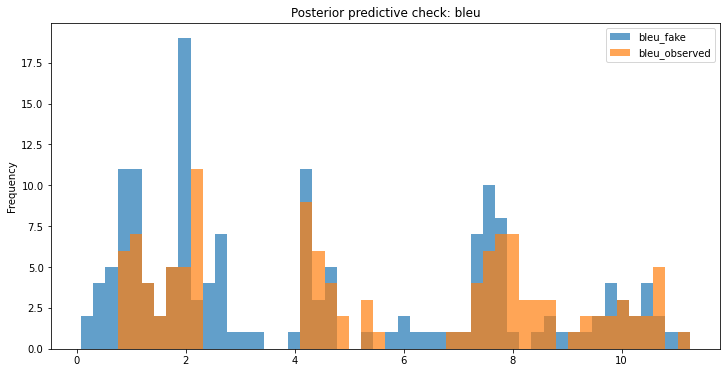

In [227]:
posterior_predictive_check(combined_results_bigmodel.bleu, posterior_pred_bleu_big, n_bins=50)

/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbf71daedd0>,
      dtype=object)

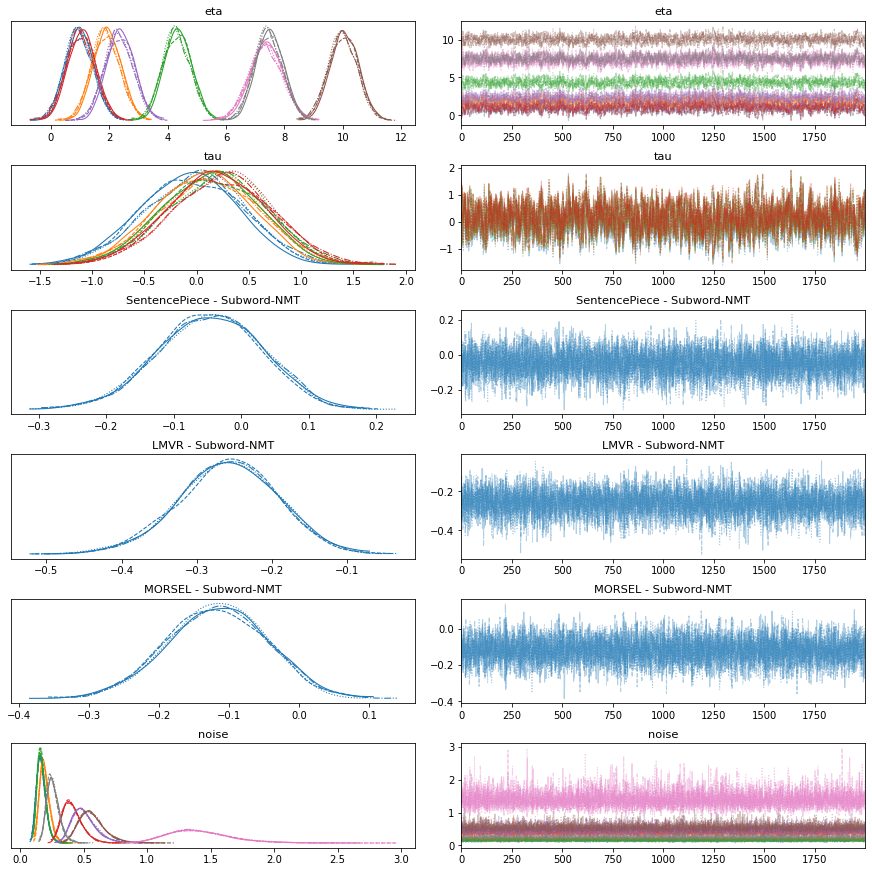

In [228]:
pm.traceplot(posterior_bleu_big)

#### CHRF3 model

In [229]:
(chrf3_model_big, 
 prior_chrf3_big, 
 posterior_chrf3_big, 
 posterior_pred_chrf3_big, 
 chrf3_lang_pair_encoder_big, 
 chrf3_segm_method_encoder_big) = fit_chrf3_normal_model(combined_results_bigmodel, 
                                                          LabelEncoder(), 
                                                          LabelEncoder(),
                                                          eta_params={'mu': 15, 'sigma': 7},
                                                          tau_params={'mu': 0, 'sigma': 1},
                                                          tune=2000, n=2000, 
                                                          target_accept=0.9,
                                                          init_str="adapt_diag")

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, tau, eta]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 37 seconds.
The number of effective samples is smaller than 25% for some parameters.
/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


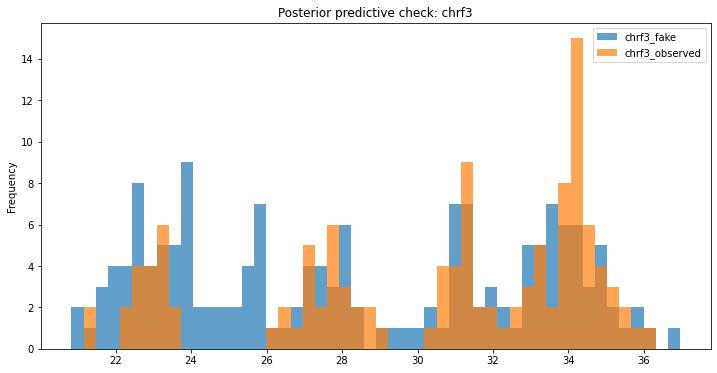

In [230]:
posterior_predictive_check(combined_results_bigmodel.chrf3, posterior_pred_chrf3_big, metric_name='chrf3', n_bins=50)

/data-drive/miniconda3/envs/work/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbf71174650>,
      dtype=object)

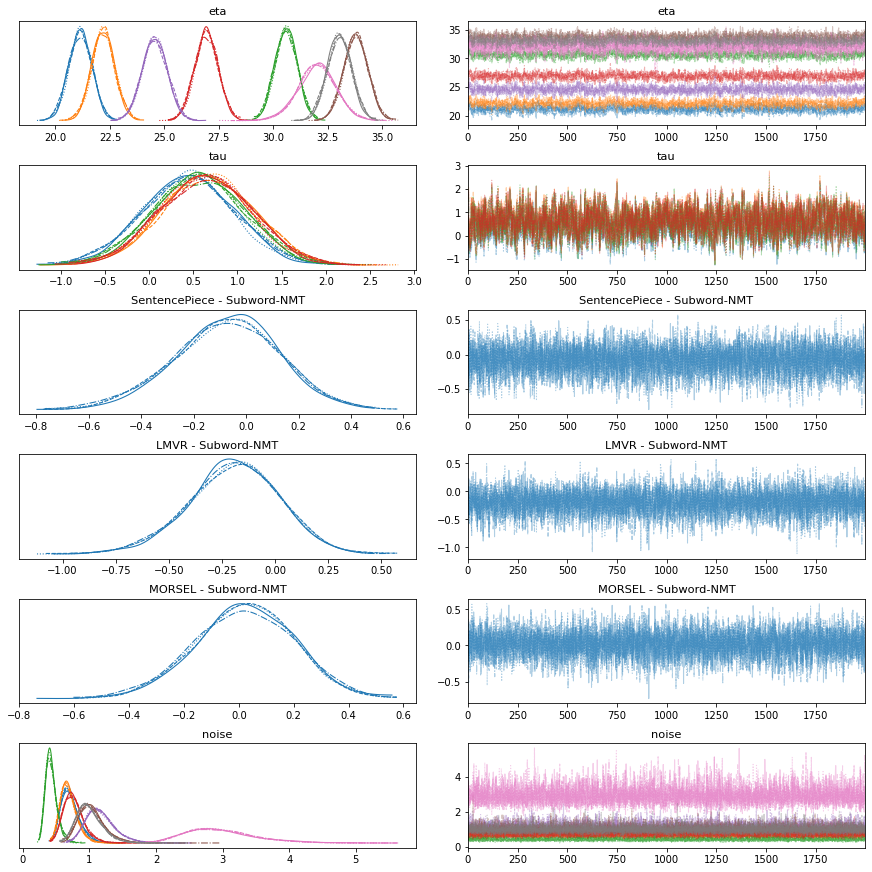

In [231]:
pm.traceplot(posterior_chrf3_big)

### Exploring noise

In [250]:
def construct_noise_df(lang_pair_enc, trace):
    noise_df = pd.DataFrame()
    noise_df['Language pair'] = lang_pair_enc.inverse_transform(range(8))
    noise_df['Eta'] = trace['eta'].mean(axis=0)
    noise_df['Noise'] = trace['noise'].mean(axis=0)
    return noise_df.set_index('Language pair')

In [251]:
bleu_noise_df = construct_noise_df(bleu_lang_pair_encoder_big, posterior_bleu_big)

In [252]:
chrf3_noise_df = construct_noise_df(chrf3_lang_pair_encoder_big, posterior_chrf3_big)

In [253]:
bleu_noise_df\
    .join(chrf3_noise_df, 
          lsuffix=' (BLEU)', 
          rsuffix=' (CHRF3)')\
    .round(3)\
    .sort_values('Noise (BLEU)', 
                 ascending=False)

,Eta (BLEU),Noise (BLEU),Eta (CHRF3),Noise (CHRF3)
Language pair,,,,
NE-EN,7.352,1.412,31.985,2.958
KK-EN (train220k),10.013,0.562,33.781,1.034
KK-EN (train120k),2.339,0.503,24.552,1.165
EN-SI,1.020,0.408,26.924,0.762
SI-EN,7.460,0.258,33.025,1.000
EN-KK (train220k),1.888,0.192,22.183,0.690
EN-NE,4.312,0.168,30.578,0.426
EN-KK (train120k),0.962,0.164,21.136,0.712


### Tau tables

In [254]:
# (tau_table_bleu_big, 
# eta_table_bleu_big) = posterior_inference_table(bleu_segm_method_encoder_big, 
#                                                 bleu_lang_pair_encoder_big, 
#                                                 posterior_bleu_big)

In [255]:
# tau_table_bleu_big

In [256]:
# tau_table_bleu.join(tau_table_bleu_old, rsuffix=" (KK: train1)", lsuffix=" (KK: train2)")

In [257]:
# eta_table_bleu_big

In [258]:
# eta_table_bleu.join(eta_table_bleu_old, rsuffix=" (KK: train1)", lsuffix=" (KK: train2)")

In [259]:
# (tau_table_chrf3_big, 
# eta_table_chrf3_big) = posterior_inference_table(chrf3_segm_method_encoder_big, 
#                                                 chrf3_lang_pair_encoder_big, 
#                                                 posterior_chrf3_big)

In [260]:
# tau_table_chrf3_big

In [261]:
# tau_table_chrf3.join(tau_table_chrf3_old, rsuffix=" (KK: train1)", lsuffix=" (KK: train2)")

In [262]:
# eta_table_chrf3_big

In [263]:
# eta_table_chrf3.join(eta_table_chrf3_old, rsuffix=" (KK: train1)", lsuffix=" (KK: train2)")

#### Differences from subword-nmt 

In [264]:
pairwise_difference_varnames = ['SentencePiece - Subword-NMT', 'LMVR - Subword-NMT', 'MORSEL - Subword-NMT']

In [265]:
def construct_pairwise_difference_table(trace, var_names):
    values = [(trace[var].mean(axis=0), trace[var].std(axis=0)) for var in var_names] 
    output = pd.DataFrame()
    output['name'] = var_names
    output['value'] = [f"{m:.2f} +/- {s:.2f}" for m,s in values]
    return output

In [266]:
construct_pairwise_difference_table(posterior_bleu_big, pairwise_difference_varnames)

,name,value
0,SentencePiece - Subword-NMT,-0.05 +/- 0.08
1,LMVR - Subword-NMT,-0.26 +/- 0.06
2,MORSEL - Subword-NMT,-0.12 +/- 0.07


In [267]:
construct_pairwise_difference_table(posterior_chrf3_big, pairwise_difference_varnames)

,name,value
0,SentencePiece - Subword-NMT,-0.08 +/- 0.20
1,LMVR - Subword-NMT,-0.20 +/- 0.21
2,MORSEL - Subword-NMT,0.02 +/- 0.18


## Plots for paper

In [268]:
for_paper = combined_results_bigmodel.copy()

In [269]:
for_paper.columns = ['Language pair', 'Segmentation method', 'Seed', 'BLEU', 'CHRF3']
for_paper['Language pair'] = for_paper['Language pair']\
                                .str.upper()\
                                .str.replace('TRAIN', 'train')#\
                                #.str.replace('train1', 'train120k')\
                                #.str.replace('train2', 'train220k')

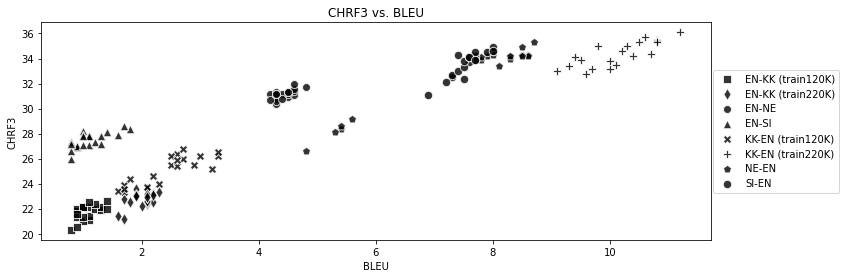

In [270]:
from itertools import cycle
plt.figure(figsize=(12, 4))
ax = plt.gca()
ax.patch.set_facecolor('#FFFFFF')
lang_pairs = for_paper.groupby('Language pair')
markers = ['s', 'd', '8', '^', 'X', 'P', 'p', 'o']
legend_labels = []
for (name, lang_pair), marker in zip(lang_pairs, cycle(markers)):
    ax.scatter(lang_pair.BLEU, lang_pair.CHRF3, 
               marker=marker, color='k', alpha=.8, 
               s=70, edgecolor='white')
    legend_labels.append(name)
ax.set_xlabel('BLEU')
ax.set_ylabel('CHRF3')
ax.legend(labels=legend_labels, loc='center right', 
          ncol=1, bbox_to_anchor=(1.2,  .5))
ax.set_title('CHRF3 vs. BLEU')
plt.show()

## Translation output tables for paper

```python
for lang_pair in lang_pairs:
    for segm_method in segm_methods:
        sample_and_display_random_output()
```

### Flores data

In [271]:
# import pickle
# import random

In [272]:
# with open('human-eval-table/human_eval_tables.pkl', 'rb') as f:
#     tables = pickle.load(f)

In [273]:
# def sample_and_display_translation_output(tables, seed=12345):
#     for lang_pair, table in tables.items():
#         lang_pair = lang_pair.upper().replace('-OLD', ' (train1)')
#         print(f"Language pair: {lang_pair}")
#         for _, row in table.sample(1, random_state=seed).iterrows():
#             print(f"Reference: {row['reference']}")
#             print(f"SentencePiece: {row['sentencepiece']}")
#             print(f"Subword-NMT: {row['subword-nmt']}")
#             print(f"LMVR: {row['lmvr-tuned']}")
#             print(f"MORSEL: {row['morsel']}")
#         print()

In [274]:
# sample_and_display_translation_output(tables, seed=1234567)

In [275]:
# def latexify_output_table(tables, seed=12345):
#     table_rows = []
#     for lang_pair, table in tables.items():
#         lang_pair = lang_pair.upper().replace('-OLD', ' (old)')
#         table_rows.append(("Language pair", lang_pair))
#         for _, row in table.sample(1, random_state=seed).iterrows():
#             table_rows.append(("Reference", row['reference']))
#             table_rows.append(("SentencePiece", row['sentencepiece']))
#             table_rows.append(("Subword-NMT", row['subword-nmt']))
#             table_rows.append(("LMVR", row['lmvr-tuned']))
#             table_rows.append(("MORSEL", row['morsel']))
#     return pd.DataFrame.from_records(table_rows)

In [276]:
# print(latexify_output_table(tables).to_latex())

## All results

In [277]:
# t = combined_results_bigmodel\
#     .groupby(['pair', 'method'])[['bleu', 'chrf3']]\
#     .describe()\
#     .round(2)[[('bleu', 'mean'), 
#                ('bleu', 'std'), 
#                ('chrf3', 'mean'), 
#                ('chrf3', 'std')]]

In [278]:
# def big_results_table(table):
#     t = table.groupby(['pair', 'method'])[['bleu', 'chrf3']]\
#     .describe()\
#     .round(2)[[('bleu', 'mean'), 
#                ('bleu', 'std'), 
#                ('chrf3', 'mean'), 
#                ('chrf3', 'std')]]
#     bleu_means = t[('bleu', 'mean')]
#     bleu_stds = t[('bleu', 'std')]
#     bleu_vals = [f"{m:.2f} +/- {s:.2f}" for m, s in zip(bleu_means, bleu_stds)]
#     chrf3_means = t[('chrf3', 'mean')]
#     chrf3_stds = t[('chrf3', 'std')]
#     chrf3_vals = [f"{m:.2f} +/- {s:.2f}" for m, s in zip(chrf3_means, chrf3_stds)]
#     t_with_ix = t.reset_index()
#     output = pd.DataFrame({'Language pair': t_with_ix.pair, 'Segmentation method': t_with_ix.method, 
#                            'BLEU': bleu_vals, 'CHRF3': chrf3_vals}, 
#                           columns=['Language pair', 'Segmentation method', 'BLEU', 'CHRF3'])
#     return output

In [279]:
# big_results_table(combined_results_bigmodel)#[['BLEU', 'CHRF3']]

## Table 3 results analysis

In [281]:
import scikit_posthocs as sp

In [282]:
table3 = combined_results_bigmodel.copy()
table3.columns = ['Language pair', 'Segmentation method', 'Seed','BLEU', 'CHRF3']
table3['Segmentation method'] = table3['Segmentation method'].apply(
    lambda sm: {'subword-nmt': "Subword-NMT", 
                'morsel': "MORSEL", 
                'sentencepiece': 
                "SentencePiece", 
                'lmvr-tuned': 'LMVR'}[sm]
)
table3['Language pair'] = table3['Language pair']#\
                            #.str.replace('train1', 'train120k')\
                            #.str.replace('train2', 'train220k')

In [309]:
table3.groupby(["Language pair", "Segmentation method"])[['BLEU', 'CHRF3']].describe()[[('BLEU', 'mean'), ('BLEU', 'std'), ('CHRF3', 'mean'), ('CHRF3', 'std')]].round(2)

BLEU        CHRF3      
                                        mean   std   mean   std
Language pair     Segmentation method                          
EN-KK (train120k) LMVR                  1.00  0.12  21.98  0.41
                  MORSEL                0.94  0.11  21.24  0.89
                  SentencePiece         1.04  0.09  21.48  0.47
                  Subword-NMT           1.32  0.08  22.12  0.28
EN-KK (train220k) LMVR                  1.82  0.13  22.74  0.84
                  MORSEL                2.06  0.11  22.88  0.40
                  SentencePiece         2.18  0.08  22.78  0.43
                  Subword-NMT           1.94  0.22  22.62  0.88
EN-NE             LMVR                  4.32  0.04  31.00  0.29
                  MORSEL                4.38  0.16  31.28  0.47
                  SentencePiece         4.58  0.15  31.36  0.35
                  Subword-NMT           4.42  0.16  30.96  0.34
EN-SI             LMVR                  1.44  0.32  28.22  0.30
                  MORSEL                1.12  0.13  27.44  0.34
                  SentencePiece         1.08  0.31  27.56  0.43
                  Subword-NMT           0.88  0.13  26.78  0.51
KK-EN (train120k) LMVR                  1.70  0.07  23.72  0.44
                  MORSEL                2.62  0.08  26.26  0.36
                  SentencePiece         2.34  0.21  24.64  0.81
                  Subword-NMT           3.14  0.18  25.92  0.54
KK-EN (train220k) LMVR                  9.42  0.26  33.88  0.76
                  MORSEL               10.44  0.48  34.58  0.88
                  SentencePiece        10.02  0.29  33.50  0.54
                  Subword-NMT          10.68  0.34  35.52  0.41
NE-EN             LMVR                  7.84  0.11  34.10  0.16
                  MORSEL                5.30  0.30  28.18  0.97
                  SentencePiece         8.42  0.23  34.40  0.73
                  Subword-NMT           8.46  0.15  34.18  0.13
SI-EN             LMVR                  7.24  0.22  32.16  0.63
                  MORSEL                7.78  0.16  34.32  0.30
                  SentencePiece         7.52  0.08  33.58  0.43
                  Subword-NMT           7.76  0.25  34.38  0.38

### Dunn's test

In [310]:
best_segm_methods = {
    "BLEU": {
        "EN-KK (train120k)": "Subword-NMT",
        "EN-KK (train220k)": "SentencePiece",
        "KK-EN (train120k)": "Subword-NMT",
        "KK-EN (train220k)": "Subword-NMT",
        "EN-NE": "SentencePiece",
        "NE-EN": "Subword-NMT",
        "EN-SI": "LMVR",
        "SI-EN": "MORSEL"
    },
    "CHRF3": {
        "EN-KK (train120k)": "Subword-NMT",
        "EN-KK (train220k)": "SentencePiece",
        "KK-EN (train120k)": "MORSEL",
        "KK-EN (train220k)": "Subword-NMT",
        "EN-NE": "SentencePiece",
        "NE-EN": "SentencePiece",
        "EN-SI": "LMVR",
        "SI-EN": "Subword-NMT"
    }
}

In [311]:
def dunns_test_analysis(table3, correction_method=None):
    output = {}
    lang_pairs = table3['Language pair'].unique()
    for lp in lang_pairs:
        output[lp] = {}
        sub_table = table3.set_index('Language pair').loc[lp]
        for metric in ("BLEU", "CHRF3"):
            best_col = best_segm_methods[metric][lp]
            output[lp][metric] = sp.posthoc_dunn(sub_table, val_col=metric, 
                                                 p_adjust=correction_method,
                                                 group_col="Segmentation method").loc[best_col]
    return output

In [312]:
dunns_results = dunns_test_analysis(table3, correction_method=None)

In [313]:
for lang_pair, results in dunns_results.items():
    for metric, dunn_table in results.items():
        print(f'Language pair: {lang_pair}')
        print(f"Metric: {metric}")
        print(dunn_table)
        print()

Language pair: EN-NE
Metric: BLEU
LMVR             0.014222
MORSEL           0.057344
SentencePiece    1.000000
Subword-NMT      0.136886
Name: SentencePiece, dtype: float64

Language pair: EN-NE
Metric: CHRF3
LMVR             0.070542
MORSEL           0.466146
SentencePiece    1.000000
Subword-NMT      0.045787
Name: SentencePiece, dtype: float64

Language pair: NE-EN
Metric: BLEU
LMVR             0.036321
MORSEL           0.000592
SentencePiece    0.872074
Subword-NMT      1.000000
Name: Subword-NMT, dtype: float64

Language pair: NE-EN
Metric: CHRF3
LMVR             0.404541
MORSEL           0.002175
SentencePiece    1.000000
Subword-NMT      0.767404
Name: SentencePiece, dtype: float64

Language pair: EN-SI
Metric: BLEU
LMVR             1.000000
MORSEL           0.245795
SentencePiece    0.070542
Subword-NMT      0.002987
Name: LMVR, dtype: float64

Language pair: EN-SI
Metric: CHRF3
LMVR             1.000000
MORSEL           0.036109
SentencePiece    0.090517
Subword-NMT      0.00

In [314]:
segm_methods = ["LMVR", "MORSEL", "SentencePiece", "Subword-NMT"]

In [315]:
bolded_counts = []
for ix, sm in enumerate(segm_methods):
    bolded_counts.append([sm, 0, 0])
    for lp, dunns_results_df in dunns_results.items():
        p_bleu = dunns_results_df['BLEU'].loc[sm]
        p_chrf3 = dunns_results_df['CHRF3'].loc[sm]
        bolded_counts[ix][1] += int(p_bleu >= 0.05)
        bolded_counts[ix][2] += int(p_chrf3 >= 0.05)

In [316]:
bolded_counts_df = pd.DataFrame.from_records(bolded_counts, columns=["Segmentation method", "BLEU", "CHRF3"])

In [317]:
print(bolded_counts_df.to_latex(index=False))

\begin{tabular}{lrr}
\toprule
Segmentation method &  BLEU &  CHRF3 \\
\midrule
               LMVR &     1 &      5 \\
             MORSEL &     6 &      6 \\
      SentencePiece &     6 &      6 \\
        Subword-NMT &     6 &      6 \\
\bottomrule
\end{tabular}

